![logo](Data/logo.png)

# Python and GIS: example using raster 

In this notebook we show how to open a true color image from sentinel 2, crop it, and project it to the standard projection system for europe, `epsg:3035`.

EPGS is a public registry of Coordinate reference systems, CRS.
CRS provide a standardized way of describing locations.Many different CRS are used to describe geographic data.
The CRS that is chosen depends on when the data was collected, the geographic extent of the data, the purpose of the data, etc.


True color image of sentinel 2 can be manually uploaded from the [apps.sentinel-hub]((https://apps.sentinel-hub.com/eo-browser/)) sever.
One image of the 16 of july 2023 in available in this repository, see `filein` variable below.

When saving true color image save them in 8-bit tiff format as indicated in the image below
![saving tiff in the sentinel server](Data/sentinelUpload.png)


some key libraries in GIS are:
 * shapely: tools for the manipulation of planar features 
 * rasterio: to hanfle raster image
 * geopandas: add to the functionality of pandas most of gis file format. It also uses functionallity of matplotlib.
 * pyproj: to transform coordinate between CRS.


### import library

In [1]:
#system
import sys
import os 
import glob

#variables type
import numpy as np 
import pandas as pd

#for plotting
import matplotlib as mpl 
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

#for gis
import geopandas as gpd
import shapely 
from shapely.geometry import Polygon
import pyproj
import rasterio 
from rasterio.mask import mask

#for image processing
import cv2

#misc
import warnings
import pdb 

#homebrewed
# here we load a module that is not part of the library available in conda.
# I wrote this module. 
# the sys.path.append command is used to tell python to add Src-tools to the place where it can find library to import.
sys.path.append('./Src-tools/')
import tools



## Variables initialisation

In [2]:

dir_data = './Data/'
crs_here = 'epsg:3035'

#projection tools betweeen WGS84 and crs_here 
to_latlon=pyproj.Transformer.from_crs(crs_here, 'epsg:4326')
to_utm=pyproj.Transformer.from_crs('epsg:4326', crs_here)

#barcelona
filein = '{:s}/2023-07-16-00 00_2023-07-16-23 59_Sentinel-2_L2A_True_color.tiff'.format(dir_data)
lon, lat = 2.214, 41.47 # cente

#window around barcelona
ll = 20.e3
ycenter, xcenter = to_utm.transform(lat,lon)
xminHere,xmaxHere = xcenter-ll, xcenter+ll
yminHere,ymaxHere = ycenter-ll, ycenter+ll


## load true color image and project on crs

In [3]:
with rasterio.open(filein) as src: # the with command release the src from the memory while the line indented below are completed
    src = rasterio.open(filein)      
    #clip
    bb = 1
    bbox = shapely.geometry.box(xminHere-bb, yminHere-bb, xmaxHere+bb, ymaxHere+bb)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=crs_here)
    geo = geo.to_crs(crs='epsg:4326')
    coords = tools.getFeatures(geo)
    data_, src_transform = mask(src, shapes=coords, crop=True)
           
    data_out = []
    for xx in range(3):
        band_, transform_dst = tools.reproject_raster(data_[xx][np.newaxis, ...], geo.total_bounds , src_transform, geo.crs, crs_here, resolution=60)
                
        if xx == 0: 
            transformer = rasterio.transform.AffineTransformer(transform_dst)
            nx,ny = band_.shape
            dst_bounds = (*transformer.xy(0, 0), *transformer.xy(nx, ny))

        data_out.append(band_)

data_out = np.array(data_out, dtype=np.uint8)
data_out = np.transpose(data_out,[1,2,0])


## project image equalization.
a conrast adjustment is performed on `data_out` using the [CLAHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization) algorithm apply to the lightness component of `data_out` projected into the [LAB color space](https://en.wikipedia.org/wiki/CIELAB_color_space),
following a [stackoverflow comment](https://stackoverflow.com/a/47370615).

In [4]:
bgr = data_out # in matplotlib color image are stored in BGR order. here we just change the name of the variable.
#rgb is projected to the lab color space
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
#run the clahe algo available in cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5,5))
#reporject the image to the RGB space.
lab_planes_new = ( clahe.apply(lab_planes[0]), lab_planes[1], lab_planes[2])
lab = cv2.merge(lab_planes_new)
bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

## plot projected true color image  

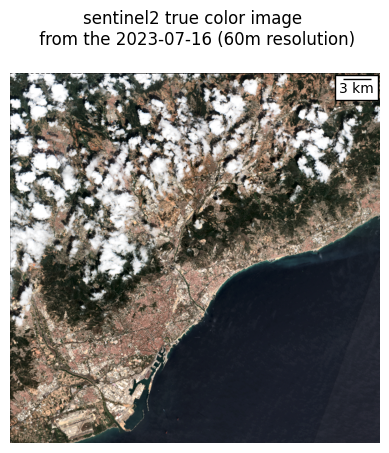

In [7]:
# %matplotlib inline


ax = plt.subplot(111)
ax.imshow(bgr, extent=(dst_bounds[0],dst_bounds[2],dst_bounds[3],dst_bounds[1]) )

    
ax.set_xlim(xminHere,xmaxHere)
ax.set_ylim(yminHere,ymaxHere)
ax.set_title('sentinel2 true color image \n from the 2023-07-16 (60m resolution)', pad=10)
ax.set_axis_off()

fontprops = fm.FontProperties(size=10)
scalebar = AnchoredSizeBar(ax.transData,
                           3000, '3 km', 'upper right', 
                           pad=.3,
                           color='k',
                           frameon=True,
                           size_vertical=10,
                           fontproperties=fontprops)

ax.add_artist(scalebar)


